<a href="https://colab.research.google.com/github/EduFdezSoy/safety-first/blob/master/simple_progressively_lowering_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Safety helmet detector

Source: https://www.kaggle.com/ehddnr301/helmet-classification

In [ ]:
# Uncomment for install tensorflow 1.15.
!pip install tensorflow==1.15

In [ ]:
# Imports
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
from skimage import io, transform
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, MaxPooling2D, Dropout
# Check Tensorflow version.
tf.version.VERSION

'1.15.0'

## 1. Loading Data

In [ ]:
# Uncomment for clonning the repository
!git clone https://github.com/sergiorodenas/ml-data.git

Cloning into 'ml-data'...
remote: Enumerating objects: 13236, done.
remote: Total 13236 (delta 0), reused 0 (delta 0), pack-reused 13236
Receiving objects: 100% (13236/13236), 64.73 MiB | 36.85 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [ ]:
# Image constants
IMAGE_WIDTH=100
IMAGE_HEIGHT=100
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
PATH1='./ml-data/helmet-dataset/Train_positive/Train_positive/'
PATH2='./ml-data/helmet-dataset/Train_negative/Train_negative/'

In [ ]:
# Getting the images
filenames_list_yes = []
filenames_list_no = []

for filename in os.listdir(PATH1):
    filenames_list_yes.append(PATH1 + filename)
    
for filename in os.listdir(PATH2):
    filenames_list_no.append(PATH2 + filename)

df_yes = pd.DataFrame({
    'image': filenames_list_yes,
    'category': np.ones(len(filenames_list_yes), str)
})
df_no = pd.DataFrame({
    'image': filenames_list_no,
    'category': np.zeros(len(filenames_list_no), str)
})
print(df_yes.shape, df_no.shape)
df = df_yes.append(df_no, ignore_index=True)
print(df['image'][0])

(5160, 2) (6580, 2)
./ml-data/helmet-dataset/Train_positive/Train_positive/4325.jpg


## 2. Training data

In [ ]:
# Hyperparameters
BATCH_SIZE=32
EPOCHS=20

In [ ]:
#split data into train and valid set
train_df, valid_df = train_test_split(df, test_size = 0.15, stratify = df['category'], random_state = 3)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]
print(train_df.shape)
print(valid_df.shape)

(9979, 2)
(1761, 2)


In [ ]:
#We'll perform individually on train and validation set.
train_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   )

train_gen = train_datagen.flow_from_dataframe(train_df,
                                              x_col = 'image',
                                              y_col = 'category',
                                              target_size = IMAGE_SIZE,
                                              batch_size = BATCH_SIZE,
                                              class_mode='binary',
                                              validate_filenames=False
                                             )

#we do not augment validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)
valid_gen = validation_datagen.flow_from_dataframe(
    valid_df, 
    x_col="image",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    validate_filenames=False
)

Found 9979 non-validated image filenames belonging to 2 classes.
Found 1761 non-validated image filenames belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', strides=(2,2), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'Precision'])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 49, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 141376)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               36192512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

## 3. Train the model

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpointer = ModelCheckpoint(filepath = 'mask.weights.best.hdf5', save_best_only = True, save_weights_only = True)
early_stop = EarlyStopping(monitor='loss', patience=3)
callbacks = [learning_rate_reduction, checkpointer, early_stop]

In [ ]:
start = time.time()

model.fit_generator(train_gen,
                    epochs = EPOCHS,
                    validation_data = valid_gen,
                    validation_steps=total_valid//BATCH_SIZE,
                    steps_per_epoch=total_train//BATCH_SIZE,
                    callbacks = callbacks)

endTime = time.time() - start
print("Total time: ", endTime, "seconds")

Epoch 1/20
311/311 [==============================] - 11s 36ms/step - loss: 0.1728 - acc: 0.9403 - precision_2: 0.9286 - val_loss: 0.0869 - val_acc: 0.9648 - val_precision_2: 0.9518
Epoch 2/20
311/311 [==============================] - 10s 33ms/step - loss: 0.0946 - acc: 0.9686 - precision_2: 0.9631 - val_loss: 0.0803 - val_acc: 0.9722 - val_precision_2: 0.9726
Epoch 3/20
311/311 [==============================] - 10s 33ms/step - loss: 0.0540 - acc: 0.9797 - precision_2: 0.9754 - val_loss: 0.0475 - val_acc: 0.9841 - val_precision_2: 0.9832
Epoch 4/20
311/311 [==============================] - 10s 32ms/step - loss: 0.0434 - acc: 0.9843 - precision_2: 0.9814 - val_loss: 0.1031 - val_acc: 0.9688 - val_precision_2: 0.9444
Epoch 5/20
 54/311 [====>.........................] - ETA: 8s - loss: 0.0722 - acc: 0.9826 - precision_2: 0.9777
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
311/311 [==============================] - 10s 34ms/step - loss: 0.0330 - acc: 

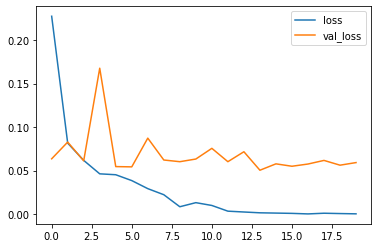

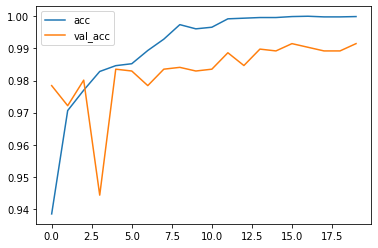

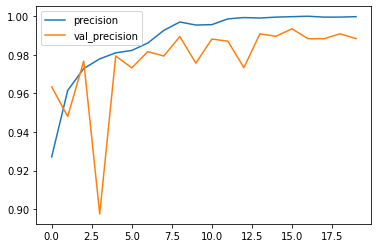

In [ ]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()
loss[['acc', 'val_acc']].plot()
loss[['precision', 'val_precision']].plot()

In [ ]:
loss_mean = loss.mean()
loss_mean

loss             0.029774
acc              0.990409
precision        0.988238
val_loss         0.068105
val_acc          0.982898
val_precision    0.977157
lr               0.000550
dtype: float64

In [ ]:
print("Epochs: ", len(model.history.epoch))
print("Train time: ", endTime, "seconds") 

Epochs:  20
Train time:  220.74680304527283 seconds


In [ ]:
print("| simple | {} | {} |  {} |   {} |  {} |      {} | {} |      {} |   {} |     |".format(loss_mean.acc, loss_mean.loss, loss_mean.val_acc, loss_mean.val_loss, loss_mean.precision, loss_mean.val_precision, loss_mean.lr, len(model.history.epoch), endTime))

| simple | 0.9904091715812683 | 0.029773769081864875 |  0.9828977227210999 |   0.06810503541299577 |  0.9882381230592727 |      0.9771572142839432 | 0.0005500000261235982 |      20 |   220.74680304527283 |     |
